# Visualizing Tatort Tweets on a Map 


@author: Andreas Pawlik (andreas.pawlik@gmail.com), 2016.

I don't claim originality on any of this. Much of the code I use is adapted fom various examples and tutorials I have found int the web. If you think I have forgotten any important references just let me know and I'll adapt the notebook.

Use the code at your own risk!

## What's that all about

In this notebook we will locate Tatort tweets on a map. Tatort is a regular crime show running every Sunday 8.15 pm on channel ARD. It's stories not of a single police team but of several, scattered in cities across Germany, and also in Austria and Switzerland. It's very popular in Germany, reaching an audience of, on average, up to 13 million people, a substantial fraction of the overall population. People even meet in bars and restaurants for public viewing.

Many of the Tatort enthusiasts also comment on the show on twitter while watching, and many of the tweets are quite fun to read. I got curious if I could render the tweets on a map, and perhaps spot some correlation of tweets with the city featured in the current show. 

While I was looking for a library that let's me quickly make a few nice-looking maps, I came across Folium, a Python libray building on Leaflet.js, a well-known and powerful Javascript library for visualization of geodata. The examples in the Folium documentation got my curious enough to give it a try. 

This notebook gives a short overview of my application of Folium to the visualization of Tatort tweets. If you got curious I would be happy to see you following you along. Besides getting to know Folium we'll also learn how to query Twitter, how to scrape Wikipedia tables, and how to figure out if a point is inside a polygon.

## Getting started

First we'll load the required library dependencies, including Twython for reading the Twitter stream, Pandas for storing and manipulating the tweeted data in a table, and Folium for visualization on a map.

In [31]:
%matplotlib inline
from matplotlib import pylab as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
import numpy as np
import pandas as pd
from pygeocoder import Geocoder
import folium
from folium import plugins
import json
from pprint import pprint
import datetime
from dateutil import tz
from functools import partial
import urllib
import os
from twython import Twython, TwythonStreamer

## Collecting the tweets

We'll use Twython to collect tweets with hashtag Tatort from Twitter. Twython provides an easy to use wrapper around the Twitter API that lets us focus on our main objective, extracting geodata of Tatort tweets. 

There are two main routes to getting the data: We can mine Twitter for past tweets or we can listen live to Twitter's stream. Here we'll employ Twython to stream to the tweets live. Towards this end we'll adopted a little class that writes these tweets to a file for later analysis, copied from this helpful blog: http://www.jackboot7.com/visualizing-tweets.html

In [3]:
## you'll get this by registring at twitter, see here: http://twython.readthedocs.org/en/latest/usage/starting_out.html
APP_KEY = ''
APP_SECRET = ''
OAUTH_TOKEN = ''
OAUTH_TOKEN_SECRET = ''


class MyStreamer(TwythonStreamer):
    # adopted from http://www.jackboot7.com/visualizing-tweets.html

    def on_success(self, data):

        with open('tweets.txt', 'a') as f:
            f.write(json.dumps(data))
            f.write('\n')

    def on_error(self, status_code, data):
        with open('errors.txt', 'a') as f:
            f.write('error: {0}: {1}'.format(status_code, data))



#stream = MyStreamer(APP_KEY, APP_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
#stream.statuses.filter(track = 'tatort')


## alternatively, we can search for past tweets
## note that we only get around 200 tweets per search, see here, for example: 
## http://stackoverflow.com/questions/19320197/twython-search-api-with-next-results/21644346#21644346
#twitter = Twython(app_key=APP_KEY, 
#            app_secret=APP_SECRET, 
#            oauth_token=OAUTH_TOKEN, 
#            oauth_token_secret=OAUTH_TOKEN_SECRET)

#search_results = twitter.search(q="#tatort", count=13000)
#pprint(search_results)


Now that we are finished collecting the tweets, lets load them in the notebook:

In [32]:
with open('tweets.txt') as f:
    d = f.readlines()
    
tweets = []
for line in d:
    tweet = json.loads(line)
    tweets.append(tweet)

print 'Total number of tweets:', len(tweets)

Total number of tweets: 13442


The variable tweets is now a list of tweets. Each tweet is a record in JSON format, as explained here: https://dev.twitter.com/overview/api/tweets, converted to Python dictionary. The top-level keys of that dict look like this (for a good visualization see http://mike.teczno.com/notes/streaming-data-from-twitter.html):

In [33]:
tweet = tweets[0] ## get first tweet
tweet.keys()

[u'contributors',
 u'truncated',
 u'text',
 u'is_quote_status',
 u'in_reply_to_status_id',
 u'id',
 u'favorite_count',
 u'source',
 u'retweeted',
 u'coordinates',
 u'timestamp_ms',
 u'entities',
 u'in_reply_to_screen_name',
 u'in_reply_to_user_id',
 u'retweet_count',
 u'id_str',
 u'favorited',
 u'user',
 u'geo',
 u'in_reply_to_user_id_str',
 u'possibly_sensitive',
 u'lang',
 u'created_at',
 u'filter_level',
 u'in_reply_to_status_id_str',
 u'place']

The geodata of the tweet can be found in a number of fields:
    * tweet['coordinates']: location in geojson format as reported by the user of client app
    * tweet['user']['location']: user-defined name of location (can be nonsense)
    * tweet['place']: the place the tweet is associated with (the tweet does not need to orinate from that place)
    
Not all fields need to be populated, so lets check if how many of our tweets have geoinformation inside:

In [34]:
count_l = 0
count_c = 0
count_p = 0
for t in tweets:
    try:
        
        if t['coordinates'] != None:
            count_c += 1
        if t['place'] != None:
            count_p += 1
        if t['user']['location'] != None:
            count_l += 1

    except:
        pass
    
print 'Number of tweets with coordinates: ', count_c
print 'Number of tweets with place: ', count_p
print 'Number of tweets with user location: ', count_l

Number of tweets with coordinates:  23
Number of tweets with place:  708
Number of tweets with user location:  9322


A large fraction (but not all) of the tweets have geoinformation. Most of that is in the field user location. For simplicity, let's focus on that.

For the further analysis it is convenient to load the tweets in a pandas dataframe

In [35]:
df = pd.DataFrame.from_records({'tweets': tweets})
df.head()

,tweets
0,"{u'contributors': None, u'truncated': False, u..."
1,"{u'contributors': None, u'truncated': False, u..."
2,"{u'contributors': None, u'truncated': False, u..."
3,"{u'contributors': None, u'truncated': False, u..."
4,"{u'contributors': None, u'truncated': False, u..."


Let's extract a few fields and expand the dataframe to simplify the analysis

In [37]:
def my_func(field, row): 
    try:
        return row[field]
    except:
        return None
 
fields = ['created_at', 'user']

for field in fields:
    _func = partial(my_func, field) ## we'll use the partial function to pass additional parameters along
    df[field] = df['tweets'].apply(_func)

    field = 'location'
df[field] = df['user'].apply(partial(my_func, field))


#def my_loc(row):
#    try:
#        loc = row['user']['location']
#    
#        if loc == None:
#            if row['place'] != None:
#                loc = row['place']['name']
#        
#        return loc
#    except:
#        return None

#df['location'] = df['tweets'].apply(my_loc)

#df.head()

## Let's have a look at the data

In [38]:
print 'Total number of tweets: ', df.shape[0]
df.dropna(inplace = True)
print 'Total number of tweets with locations: ', len(df.location)
print 'Number of unique locations: ', len(df.location.unique())

Total number of tweets:  13442
Total number of tweets with locations:  9322
Number of unique locations:  1721


Let's plot the number of tweets. Let's first bring the time information into a more usable format:

In [40]:
def _func(row):
    
        timestamp = row['created_at']
        utc = datetime.datetime.strptime(timestamp, '%a %b %d %H:%M:%S +0000 %Y')
        
        ## http://stackoverflow.com/questions/4770297/python-convert-utc-datetime-string-to-local-datetime
        from_zone = tz.tzutc()
        to_zone = tz.tzlocal()

        # Tell the datetime object that it's in UTC time zone since 
        # datetime objects are 'naive' by default
        utc = utc.replace(tzinfo=from_zone)

        # Convert time zone
        local = utc.astimezone(to_zone)
        
        hour = local.hour
        minute = local.minute

        return local 

df['datetime'] = df.apply(_func, axis = 1) 
df.sort_values('datetime', inplace = True)
df[['tweets', 'location']].head()

,tweets,location
3,"{u'contributors': None, u'truncated': False, u...",Stuttgart
4,"{u'contributors': None, u'truncated': False, u...",Nürnberg
5,"{u'contributors': None, u'truncated': False, u...",Auf der Mainseite
7,"{u'contributors': None, u'truncated': False, u...",Germany Münster
8,"{u'contributors': None, u'truncated': False, u...",Zwickau Deutschland


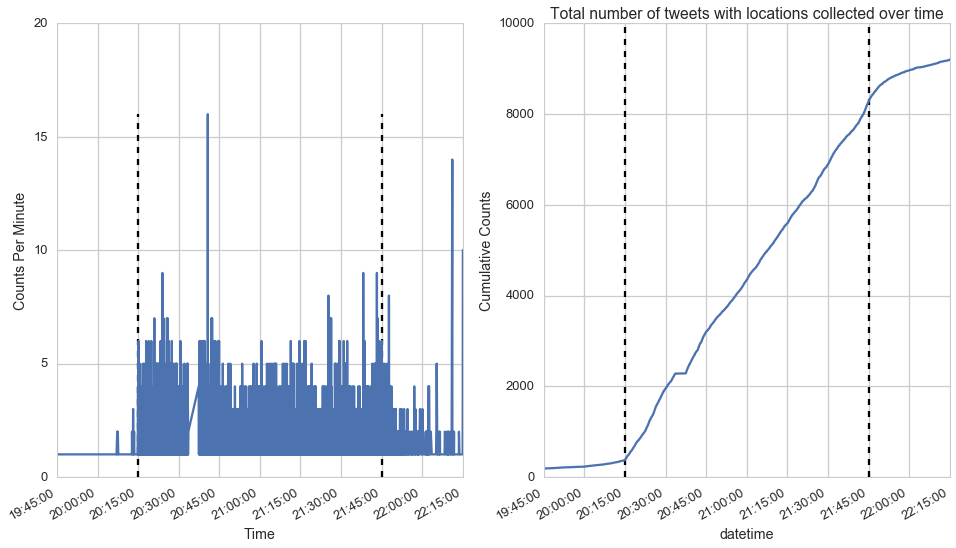

In [41]:
grouped = df.groupby(df.datetime)
counts = grouped.count()['tweets']

fig, axes = plt.subplots(1,2)
fig.set_size_inches(16,9)
ax, ax2 = axes

counts.plot(ax = ax)

t_start = datetime.datetime(2016, 3, 28, 20, 15).replace(tzinfo=tz.tzlocal())
t_end = datetime.datetime(2016, 3, 28, 21, 45).replace(tzinfo=tz.tzlocal())

ax.vlines(t_start, ax.get_ylim()[0], ax.get_ylim()[1], linestyle ='--')
ax.vlines(t_end, ax.get_ylim()[0], ax.get_ylim()[1], linestyle ='--')


ax.set_ylim([0,20])
ax.set_xlim([datetime.datetime(2016, 3, 28, 19, 45).replace(tzinfo=tz.tzlocal()),
             datetime.datetime(2016, 3, 28, 22, 15).replace(tzinfo=tz.tzlocal())])

ax.set_yscale('linear')
ax2.set_title('Numer of tweets with locations collected per minute')
ax.set_ylabel('Counts Per Minute')
ax.set_xlabel('Time')

##second panel
counts.cumsum().plot(ax = ax2)

ax2.set_title('Total number of tweets with locations collected over time')
ax2.set_ylabel('Cumulative Counts')
ax2.set_xlim([datetime.datetime(2016, 3, 28, 19, 45).replace(tzinfo=tz.tzlocal()),
             datetime.datetime(2016, 3, 28, 22, 15).replace(tzinfo=tz.tzlocal())])
ax2.vlines(t_start, ax2.get_ylim()[0], ax2.get_ylim()[1], linestyle ='--')
res = ax2.vlines(t_end, ax2.get_ylim()[0], ax2.get_ylim()[1], linestyle ='--')


There is a period of no tweets near 20:30:00 where my laptop went off.

Let's look at the top most frequent locations in our dataset:

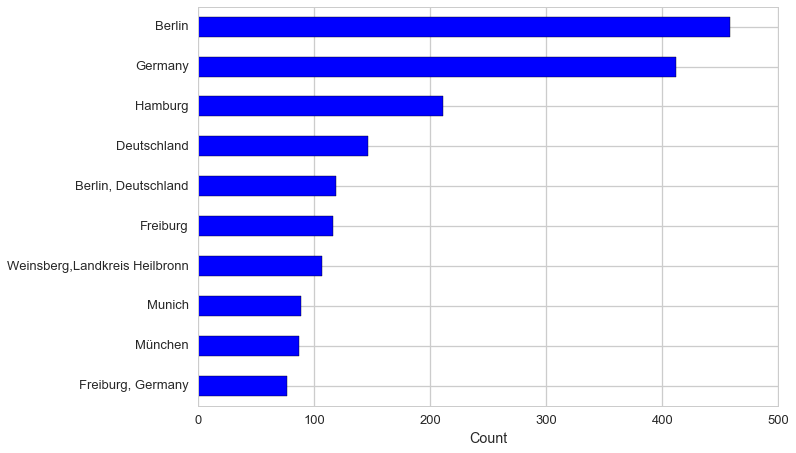

In [44]:
fig, ax = plt.subplots()
top_n = 10
df['location'].value_counts().sort_values(ascending=False)[:top_n][::-1].plot(kind = 'barh', ax = ax)
ax.set_xlabel('Count')


Some locations are pretty general ('Germany'), some locations cannot be easily put on a map. However, it's interesting and reassuring to see Freiburg up high, which is the scene of the Tatort under investigation.

## Locating the tweets

To locate the tweets on a map, we need to transform the location names into geographical information such as lattitude and longitude. We will use the Python library Geocoder, a wrapper around the Google API, to accomplish this. 

The Google API allows us to make at most 2500 requests per day without paying. So either we'll either need to split the requests over several day or somehow reduce our collection of tweets. Here we reduce our collection of tweets by random sampling. 

In [46]:
n_sample = 1000  
dfs = df.sample(n=np.min([n_sample, df.shape[0]]))
dfs.sort_values('datetime', inplace = True)
print 'Number of tweets: ', dfs.shape[0]
#dfs.head()

Number of tweets:  1000


In [47]:
geo_dict = {}
failed = []

def _func(row):
    loc = row['location']
    
    if geo_dict.has_key(loc):
        return geo_dict[loc]
    
    try:
        geo = Geocoder.geocode(loc)
        ## there were some problems with directly storing the geo object, so 
        ## we'll store the json instead
        geo_json = json.dumps(geo.current_data) 
        geo_dict[loc] = geo_json
        return geo_json
    except:
        failed.append(loc)
        return None

dfs['geo'] = dfs.apply(_func, axis=1)

print 'Number of tweets for which no longitude/lattitude could be received:', len(failed)

Number of tweets for which no longitude/lattitude could be received: 139


In [53]:
dfs.dropna(inplace = True) ## let's drop all tweets for which no longitude/lattitude could be received
print 'Number of tweets: ', dfs.shape[0]
dfs[['tweets', 'location', 'geo']].head()

Number of tweets:  861


,tweets,location,geo
24,"{u'contributors': None, u'truncated': False, u...",Frankfurt am Main,"{""geometry"": {""location_type"": ""APPROXIMATE"", ..."
27,"{u'contributors': None, u'truncated': False, u...",Frankfurt am Main,"{""geometry"": {""location_type"": ""APPROXIMATE"", ..."
65,"{u'contributors': None, u'truncated': False, u...","Germany, Augsburg","{""geometry"": {""location_type"": ""APPROXIMATE"", ..."
72,"{u'contributors': None, u'truncated': False, u...",Mainz,"{""geometry"": {""location_type"": ""APPROXIMATE"", ..."
89,"{u'contributors': None, u'truncated': False, u...",Berlin / Germany,"{""geometry"": {""location_type"": ""APPROXIMATE"", ..."


Some final data wrangling to separate the interesting bits (lattitude and longitude) from the geo object:

In [55]:
def my_func(field, row):
    
    try:
        d = json.loads(row)
        return json.dumps(d[field])        
    except:
        return np.nan


field = 'geometry'
dfs[field] = dfs['geo'].apply(partial(my_func, field))

field = 'location'
dfs['latlon'] = dfs['geometry'].apply(partial(my_func, field))

field = 'lat'
dfs[field] = dfs['latlon'].apply(partial(my_func, field))

field = 'lng'
dfs['lon'] = dfs['latlon'].apply(partial(my_func, field))

#dfs.head()

## Visualizing tweet activity

Finally we are in the position to show the location of tweets on a map. Folium's heatmap plugin comes in nicely:

In [74]:
# Create a heatmap with the data.
data = zip([float(x) for x in dfs.lat.tolist()], [float(x) for x in dfs.lon.tolist()])

heatmap_map = folium.Map(location=[51, 10.5], zoom_start=6, tiles = 'OpenStreetMap')

heatmap_map.add_children(plugins.HeatMap(data, radius = 20))


Perhaps most surprising is the large number of tweets outside Germany. We know that Tatort is popular also in Austria, Switzerland, where it also features teams, and also in some neighboring countries, such as Netherlands. But what about the locations in America, Africa, Australia? Is it all expats or is something else going on?

## Taking a closer look

Here we'll verify the locations of the tweets reported by the Google API by comparison with the locations on the map, and the locations attached to the tweets. 

We'll use Folium's markers to show the Google API location of each tweet. We'll use Folium's popup feature to display the location of the tweets.

In [57]:
#https://github.com/isellsoap/deutschlandGeoJSON/tree/master/2_bundeslaender
state_geo = r'/Users/apw/germany_niedrig.geojson.txt'

map = folium.Map(location=[51, 10.5], zoom_start=6)
map.geo_json(geo_path=state_geo, )
failed = []
for i in range(len(dfs.lat.tolist())):
    try:
               
        text = dfs.tweets.tolist()[i]['text']
        
        try: ## check if text is a proper string
            str(text) 
            #popup = text + '\n Location: ' + dfs.location.tolist()[i]
            popup = dfs.location.tolist()[i]
            map.simple_marker([dfs.lat.tolist()[i], dfs.lon.tolist()[i]], popup = popup, marker_color='blue')
            
        except:       
            ptext = text.encode('ascii', errors = 'ignore') ## this is a problem with how I saved the tweets to file?
            #popup =  '+'.join(ptext.split('\r')) + '\n Location: ' + dfs.location.tolist()[i]
            popup = dfs.location.tolist()[i]
            map.simple_marker([dfs.lat.tolist()[i], dfs.lon.tolist()[i]], popup = popup, marker_color='blue')

    except:
        ## cannot read tweet text, show the full tweet
        popup = dfs.tweets.tolist()[i]
        map.simple_marker([dfs.lat.tolist()[i], dfs.lon.tolist()[i]], popup = popup, marker_color='red')

map.create_map(path='germany.html')

from IPython.display import IFrame
IFrame('germany.html', width=800, height=800)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: simple_marker is deprecated. Use add_children(Marker) instead
/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: simple_marker is deprecated. Use add_children(Marker) instead
/Library/Python/2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: Map.create_map is deprecated. Use Map.save instead


We conclude that many tweets located outside Germany are mislocated. In the following, let's focus on the tweets in Germany.

## Ready for some analytics

Which federal country was most actively tweeting Tatort tweets, say in units of tweets per population? 

To answer this question, we'll get a list of polygons describing the boundaries of the coutries and count the number of tweets falling inside each polygon. We'll also scrape Wikipedia for the countries' population size. We'll then compute the result and visualize it on a Folium choropleth map.

First we'll get the boundaries of the federal countries. This can be done in many ways, here we'll use a geojson collection from https://github.com/isellsoap/deutschlandGeoJSON.

In [58]:
##https://github.com/isellsoap/deutschlandGeoJSON
url = "https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/master/2_bundeslaender/4_niedrig.geojson"
response = urllib.urlopen(url)
boundaries = json.loads(response.read())

## lets look at an example geojson polygon
pprint (boundaries['features'][2])

{u'geometry': {u'coordinates': [[[13.161809921264762, 52.59442138671869],
                                 [13.216209411621207, 52.58251953125006],
                                 [13.230238914489803, 52.62681198120117],
                                 [13.272738456726188, 52.62248992919922],
                                 [13.28633975982666, 52.655658721923885],
                                 [13.370199203491268, 52.62105941772461],
                                 [13.474988937378043, 52.649169921875],
                                 [13.45722961425787, 52.66054916381836],
                                 [13.482250213623047, 52.67502212524414],
                                 [13.529389381408748, 52.640949249267635],
                                 [13.514860153198356, 52.5892715454101],
                                 [13.663810729980526, 52.5277099609375],
                                 [13.618619918823356, 52.4690895080567],
                                 [13.768408

We can now assign each tweet a federal countrie by checking if it's location is inside the corresponding geojson polygon:

In [64]:
##from http://geospatialpython.com/2011/01/point-in-polygon.html

# Determine if a point is inside a given polygon or not
# Polygon is a list of (x,y) pairs. This function
# returns True or False.  The algorithm is called
# the "Ray Casting Method".

def point_in_poly(x,y,poly):

    n = len(poly)
    inside = False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside


def func(row):
    
    for f in boundaries['features']:       
        
        if f['geometry']['type'].lower() == 'polygon':
            polygon = f['geometry']['coordinates'][0]
            
    
            try:
                if point_in_poly(float(row.lon), float(row.lat), polygon):
                    return f['properties']['NAME_1']
            except:
            
                #print type(polygon)
                return 'Error' 
                 

        if f['geometry']['type'].lower() == 'multipolygon':
            polygons = f['geometry']['coordinates'][0]
            for polygon in polygons:
                try:
                    if point_in_poly(float(row.lon), float(row.lat), polygon):
                        return f['properties']['NAME_1']
                except:
            
                    #print 'error multip'
                    return 'Error multip'
                
    #print 'unknown'
    return 'Unknown'

dfs['fed'] = dfs.apply(func, axis = 1)
dfs[['tweets', 'location', 'fed']].head()

,tweets,location,fed
24,"{u'contributors': None, u'truncated': False, u...",Frankfurt am Main,Hessen
27,"{u'contributors': None, u'truncated': False, u...",Frankfurt am Main,Hessen
65,"{u'contributors': None, u'truncated': False, u...","Germany, Augsburg",Bayern
72,"{u'contributors': None, u'truncated': False, u...",Mainz,Rheinland-Pfalz
89,"{u'contributors': None, u'truncated': False, u...",Berlin / Germany,Berlin


Lets get a count of tweets in the federal countries:

In [65]:
fed_counts = pd.DataFrame({'count' : dfs.groupby( [ "fed"] ).size()}).reset_index()
fed_counts.sort_values('count', ascending = False)

,fed,count
15,Unknown,166
0,Baden-Württemberg,131
8,Nordrhein-Westfalen,125
2,Berlin,106
1,Bayern,69
14,Thüringen,64
6,Hessen,50
7,Niedersachsen,46
5,Hamburg,44
11,Sachsen,25


Let's now compare the number of tweets in each federal country with the number of people living in it. We'll get the number of people per country from Wikipedia. We'll use the webscraping tool BeautifulSoup, following the tutorial at https://adesquared.wordpress.com/2013/06/16/using-python-beautifulsoup-to-scrape-a-wikipedia-table/.

In [66]:
##scrape a table from wikipidea
##see https://adesquared.wordpress.com/2013/06/16/using-python-beautifulsoup-to-scrape-a-wikipedia-table/

from bs4 import BeautifulSoup
import urllib2

wiki = 'https://de.wikipedia.org/wiki/Land_(Deutschland)'
header = {'User-Agent': 'Mozilla/5.0'} #Needed to prevent 403 error on Wikipedia
req = urllib2.Request(wiki,headers=header)
page = urllib2.urlopen(req)
soup = BeautifulSoup(page)
 
area = ""
district = ""
town = ""
county = ""
table = soup.find("table", { "class" : "wikitable sortable zebra" })
 
names = []
populations = []
for row in table.findAll("tr"):
    cells = row.findAll("td")

    if len(cells) == 13:
        
        nr = cells[0].find(text=True)
        name = cells[1].findAll(text=True)
        population = cells[9].find(text=True)
        
        names.append(name[0])
        populations.append(float(population.replace('.','').replace(',','.')))


dfs_area = pd.DataFrame({'fed': names, 'population': populations}) 
dfs_area

,fed,population
0,Baden-Württemberg,10.631
1,Bayern,12.604
2,Berlin,3.422
3,Brandenburg,2.449
4,Bremen,0.657
5,Hamburg,1.746
6,Hessen,6.045
7,Mecklenburg-Vorpommern,1.597
8,Niedersachsen,7.791
9,Nordrhein-Westfalen,17.572


We can merge the above table with the number of counts per country computed earlier to derive at the desired result:

In [67]:
## merge on right is important to accomodate countries with zero count
fed_counts = pd.merge(fed_counts, dfs_area, on='fed', how = 'right') 
fed_counts.fillna(0, inplace = True)
## actually, it's tweets per million heads
fed_counts['tweetsPerHead'] = fed_counts.apply(lambda row: row['count'] / row['population'], axis = 1)
fed_counts

,fed,count,population,tweetsPerHead
0,Baden-Württemberg,131,10.631,12.322453
1,Bayern,69,12.604,5.474453
2,Berlin,106,3.422,30.976037
3,Brandenburg,7,2.449,2.858310
4,Bremen,9,0.657,13.698630
5,Hamburg,44,1.746,25.200458
6,Hessen,50,6.045,8.271299
7,Niedersachsen,46,7.791,5.904248
8,Nordrhein-Westfalen,125,17.572,7.113590
9,Rheinland-Pfalz,12,3.994,3.004507


And here are some Folium choropleth visualization that help us interpret the results. First, we'll show the number of counts per federal country.

In [70]:
map = folium.Map(location=[48.139, 11.566], zoom_start=5)

map.choropleth(geo_path=state_geo, data=fed_counts,
             columns=['fed', 'count'],
             key_on='feature.properties.NAME_1',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Number of tweets')

map.create_map(path='number.html')

from IPython.display import IFrame
IFrame('number.html', width=700, height=700)



/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: Map.create_map is deprecated. Use Map.save instead


We see that Nordrhein-Westfahlen und Bayern are among the countries with the most tweets. But those are also among the counries with the largests population, so this might not be so surprising. 

Let's normalize the tweet counts by dividing by the population number. The following choropleth map shows the tweets per head:

In [72]:
map = folium.Map(location=[48.139, 11.566], zoom_start=5)

map.choropleth(geo_path=state_geo, data=fed_counts,
             columns=['fed', 'tweetsPerHead'],
             key_on='feature.properties.NAME_1',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Tweets Per Head')

map.create_map(path='tweets_per_head.html')

from IPython.display import IFrame
IFrame('tweets_per_head.html', width=700, height=700)



/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: Map.create_map is deprecated. Use Map.save instead


That's funny. Thüringen turns out to have the most active Tatort tweets. Or does it?

We'll understand this result better by noting that many tweets have location Germany. The Google API returns longitude and lattitude information that locates Germany in Thüringen. Let's verify this:

In [73]:
map = folium.Map(location=[48.139, 11.566], zoom_start=5)

map.choropleth(geo_path=state_geo, data=fed_counts,
             columns=['fed', 'tweetsPerHead'],
             key_on='feature.properties.NAME_1',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Tweets Per Head')

##Geocoder.geocode('Deutschland').coordinates
map.simple_marker([51.165691,10.451526], marker_color='red')

map.create_map(path='tweets_per_head.html')

from IPython.display import IFrame
IFrame('tweets_per_head.html', width=700, height=700)


/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.
/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: simple_marker is deprecated. Use add_children(Marker) instead
/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: Map.create_map is deprecated. Use Map.save instead
